In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator

# Set display options and plot style
pd.set_option('display.max_columns', 100)
%matplotlib inline
sns.set_style("whitegrid")

print("All libraries imported successfully.")

All libraries imported successfully.


In [ ]:
# Define the columns necessary for features and outcome variables
columns_to_keep = [
    # Loan characteristics
    'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
    
    # Borrower characteristics
    'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'dti',
    
    # Outcome variables (for building survival target T and E)
    'loan_status', 'issue_d', 'last_pymnt_d'
]

# Columns to be parsed as datetime objects
date_cols = ['issue_d', 'last_pymnt_d']

filepath = '../data/accepted_2007_to_2018Q4.csv.gz' 

# Load the dataset
print("Loading data... This may take a minute")
df = pd.read_csv(
    filepath, 
    usecols=columns_to_keep, 
    parse_dates=date_cols,
    
    # Specify date format to ensure correct parsing
    date_format='%b-%Y', 
    
    compression='gzip',
    low_memory=False
)
print(f"Data loaded successfully! Shape: {df.shape}")

# Display the first 5 rows and data types
print(df.head())
df.info()

Loading data... This may take a minute.
Data loaded successfully! Shape: (2260701, 13)
   loan_amnt        term  int_rate grade sub_grade emp_length home_ownership  \
0     3600.0   36 months     13.99     C        C4  10+ years       MORTGAGE   
1    24700.0   36 months     11.99     C        C1  10+ years       MORTGAGE   
2    20000.0   60 months     10.78     B        B4  10+ years       MORTGAGE   
3    35000.0   60 months     14.85     C        C5  10+ years       MORTGAGE   
4    10400.0   60 months     22.45     F        F1    3 years       MORTGAGE   

   annual_inc    issue_d loan_status             purpose    dti last_pymnt_d  
0     55000.0 2015-12-01  Fully Paid  debt_consolidation   5.91   2019-01-01  
1     65000.0 2015-12-01  Fully Paid      small_business  16.06   2016-06-01  
2     63000.0 2015-12-01  Fully Paid    home_improvement  10.78   2017-06-01  
3    110000.0 2015-12-01     Current  debt_consolidation  17.06   2019-02-01  
4    104433.0 2015-12-01  Fully Paid 

In [ ]:
# 1. Filter for only completed loans
# We model only loans with a final status: 'Fully Paid' or 'Charged Off'.
df_clean = df[
    (df['loan_status'] == 'Fully Paid') | 
    (df['loan_status'] == 'Charged Off')
].copy()

# 2. Create the 'event' column (E)
# E = 1 if default occurred ('Charged Off'), E = 0 if payment completed ('Fully Paid').
df_clean['event'] = (df_clean['loan_status'] == 'Charged Off').astype(int)

# 3. Create the 'duration' column (T)
# Calculate time (in months) from loan issue to last payment date.
duration_days = (df_clean['last_pymnt_d'] - df_clean['issue_d']).dt.days
df_clean['duration_months'] = (duration_days / 30.44).round(0)

# 4. Handle data quality issues
# Remove loans with zero or negative duration (data errors).
df_clean = df_clean[df_clean['duration_months'] > 0].copy()

print(f"Data shape after filtering: {df_clean.shape}")
print("\nCheck the new 'event' and 'duration_months' columns:")
print(df_clean[['loan_status', 'event', 'duration_months']].head())

print("\nEvent breakdown (Default Rate):")
print(df_clean['event'].value_counts(normalize=True))

Data shape after filtering: (1334032, 15)

Check the new 'event' and 'duration_months' columns:
  loan_status  event  duration_months
0  Fully Paid      0             37.0
1  Fully Paid      0              6.0
2  Fully Paid      0             18.0
4  Fully Paid      0              7.0
5  Fully Paid      0             17.0

Event breakdown (Default Rate):
event
0    0.800431
1    0.199569
Name: proportion, dtype: float64


In [ ]:
# Convert 'term' from string ('36 months') to integer (36)
df_clean['term'] = df_clean['term'].str.replace(' months', '', regex=False).astype(int)

# Map text values in 'emp_length' to numerical years of employment
emp_length_map = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
df_clean['emp_length'] = df_clean['emp_length'].map(emp_length_map)

# Fill missing 'emp_length' (NaN) with 0, assuming lack of data means no reported employment history
df_clean['emp_length'] = df_clean['emp_length'].fillna(0)

print("Cleaned 'term' and 'emp_length':")
df_clean.info()

Cleaned 'term' and 'emp_length':
<class 'pandas.core.frame.DataFrame'>
Index: 1334032 entries, 0 to 2260697
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   loan_amnt        1334032 non-null  float64       
 1   term             1334032 non-null  int64         
 2   int_rate         1334032 non-null  float64       
 3   grade            1334032 non-null  object        
 4   sub_grade        1334032 non-null  object        
 5   emp_length       1334032 non-null  float64       
 6   home_ownership   1334032 non-null  object        
 7   annual_inc       1334032 non-null  float64       
 8   issue_d          1334032 non-null  datetime64[ns]
 9   loan_status      1334032 non-null  object        
 10  purpose          1334032 non-null  object        
 11  dti              1333668 non-null  float64       
 12  last_pymnt_d     1334032 non-null  datetime64[ns]
 13  event            1334032 non-

In [8]:
# Check for nulls before dropping
print(f"Nulls before dropping:\n{df_clean.isnull().sum()}")

# Drop any remaining rows with null values in our key columns
original_rows = df_clean.shape[0]
df_clean = df_clean.dropna(
    subset=['dti', 'annual_inc', 'emp_length']
).copy()

print(f"\nDropped {original_rows - df_clean.shape[0]} rows with nulls.")
print(f"Final clean data shape: {df_clean.shape}")

Nulls before dropping:
loan_amnt            0
term                 0
int_rate             0
grade                0
sub_grade            0
emp_length           0
home_ownership       0
annual_inc           0
issue_d              0
loan_status          0
purpose              0
dti                364
last_pymnt_d         0
event                0
duration_months      0
dtype: int64

Dropped 364 rows with nulls.
Final clean data shape: (1333668, 15)


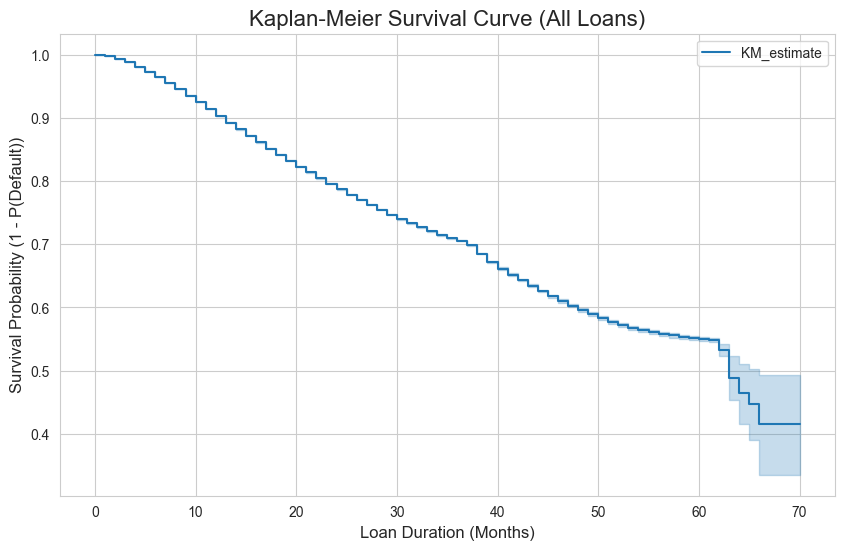

In [9]:
# Get our two main variables
T = df_clean['duration_months']
E = df_clean['event']

# Fit the Kaplan-Meier model using the lifelines library
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Create the plot
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve (All Loans)', fontsize=16)
plt.xlabel('Loan Duration (Months)', fontsize=12)
plt.ylabel('Survival Probability (1 - P(Default))', fontsize=12)

plt.show()

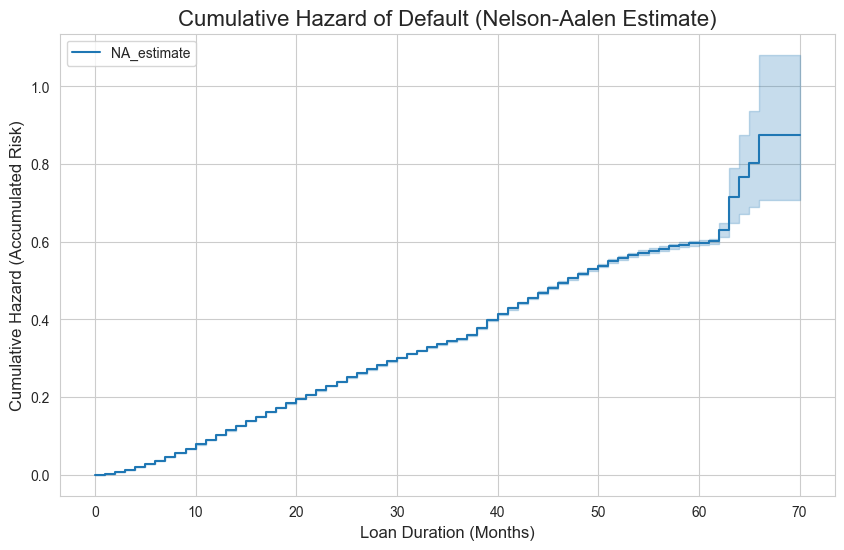

In [11]:
# Import the correct fitter for the cumulative hazard
from lifelines import NelsonAalenFitter

# Get our two main variables
T = df_clean['duration_months']
E = df_clean['event']

# Fit the Nelson-Aalen model
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)

# Create the plot
plt.figure(figsize=(10, 6))
naf.plot_cumulative_hazard()

plt.title('Cumulative Hazard of Default (Nelson-Aalen Estimate)', fontsize=16)
plt.xlabel('Loan Duration (Months)', fontsize=12)
plt.ylabel('Cumulative Hazard (Accumulated Risk)', fontsize=12)

plt.show()

In [14]:
# Define a path for our new, clean file
output_path = '../data/cleaned_loan_data.parquet'

# Save to Parquet
try:
    df_clean.to_parquet(output_path, index=False, engine='fastparquet')
    print(f"Successfully saved cleaned data to {output_path} (using fastparquet)")
    print(f"We are now 100% ready for modeling!")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please make sure you ran 'pip install fastparquet' in your terminal.")

Successfully saved cleaned data to ../data/cleaned_loan_data.parquet (using fastparquet)
We are now 100% ready for modeling!
